# Импорты

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sqlalchemy import create_engine, text

In [2]:
RANDOM_STATE = 190224

# Загрузка и анализ данных

## Загрузка данных

In [3]:
db_config = {
'user': 'praktikum_student',# имя пользователя
'pwd': 'Sdf4$2;d-d30pp',# пароль
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432,# порт подключения
'db': 'data-science-final'# название базы данных,
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [4]:
engine = create_engine(connection_string)
del db_config
del connection_string

In [5]:
data_arc = None
data_bulk = None
data_bulk_time = None
data_gas = None
data_temp = None
data_wire = None
data_wire_time = None

TABLES = [data_arc,
          data_bulk,
          data_bulk_time,
          data_gas,
          data_temp,
          data_wire,
          data_wire_time]

DB_TABLES = ['steel.data_arc',
             'steel.data_bulk',
             'steel.data_bulk_time',
             'steel.data_gas',
             'steel.data_temp',
             'steel.data_wire',
             'steel.data_wire_time']

for i, table in enumerate(TABLES):
    query = f'''
        SELECT *
        FROM {DB_TABLES[i]};
        '''

    TABLES[i] = pd.read_sql_query(query, engine)

data_arc, data_bulk, data_bulk_time, data_gas, data_temp, data_wire, data_wire_time = TABLES


## Данные об электродах

Таблица steel.data_arc
* key — номер партии;
* BeginHeat — время начала нагрева;
* EndHeat — время окончания нагрева;
* ActivePower — значение активной мощности;
* ReactivePower — значение реактивной мощности.

In [6]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            14876 non-null  int64  
 1   BeginHeat      14876 non-null  object 
 2   EndHeat        14876 non-null  object 
 3   ActivePower    14876 non-null  float64
 4   ReactivePower  14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [7]:
data_arc.describe()

,key,ActivePower,ReactivePower
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


In [8]:
data_arc.sample(5)

,key,BeginHeat,EndHeat,ActivePower,ReactivePower
6842,1487,00:21:21,00:23:32,0.444564,0.286641
2396,517,14:41:39,14:45:25,0.956563,0.775012
9951,2154,05:46:55,05:49:59,0.821028,0.603400
11029,2400,17:23:37,17:25:37,0.399554,0.379016
12741,2767,22:27:31,22:30:47,0.820709,0.719873


In [9]:
for column in ['BeginHeat', 'EndHeat']:
    data_arc[column] = data_arc[column].fillna('00:00:00')

for column in ['BeginHeat', 'EndHeat']:
    data_arc[column] = pd.to_datetime(data_arc[column], format='%H:%M:%S').dt.hour * 60 + pd.to_datetime(data_arc[column], format='%H:%M:%S').dt.minute


In [10]:
data_arc.duplicated().sum()

0

In [11]:
data_arc[data_arc['ReactivePower'] < 0]

,key,BeginHeat,EndHeat,ActivePower,ReactivePower
9781,2116,44,46,0.495782,-715.504924


In [12]:
data_arc_analysis = data_arc.copy()
data_arc_analysis = data_arc_analysis.drop(data_arc_analysis.query('key == 2116').index).reset_index(drop=True)

### Аналитика

/Users/vs/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


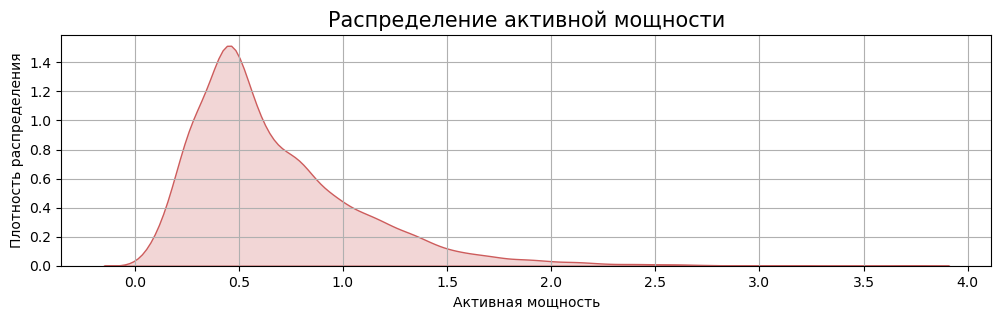

In [13]:
plt.figure(figsize=(12, 3))

sns.kdeplot(data_arc_analysis['ActivePower'], color='indianred', legend=True, fill=True)
plt.xlabel('Активная мощность')
plt.ylabel('Плотность распределения')
plt.title('Распределение активной мощности', fontsize=15)
plt.grid();

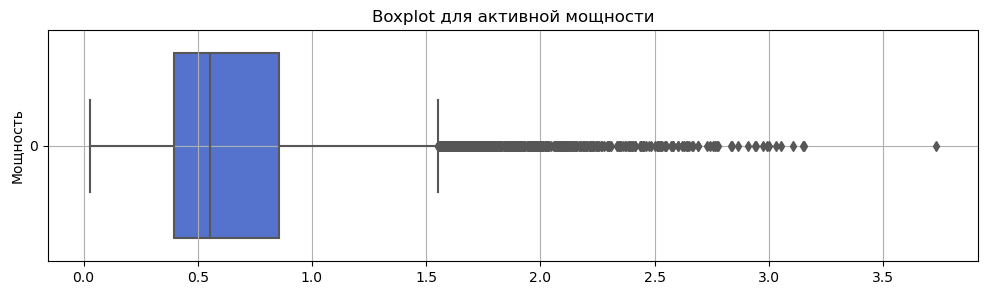

In [14]:
plt.figure(figsize=(12, 3))

sns.boxplot(data=data_arc_analysis['ActivePower'], color='royalblue', orient='h')
plt.title('Boxplot для активной мощности')
plt.ylabel('Мощность')
plt.grid();

/Users/vs/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


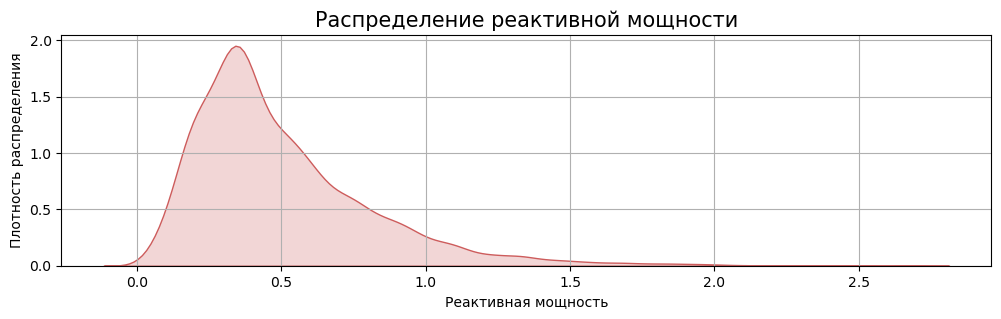

In [15]:
plt.figure(figsize=(12, 3))

sns.kdeplot(data_arc_analysis['ReactivePower'], color='indianred', legend=True, fill=True)
plt.xlabel('Реактивная мощность')
plt.ylabel('Плотность распределения')
plt.title('Распределение реактивной мощности', fontsize=15)
plt.grid();

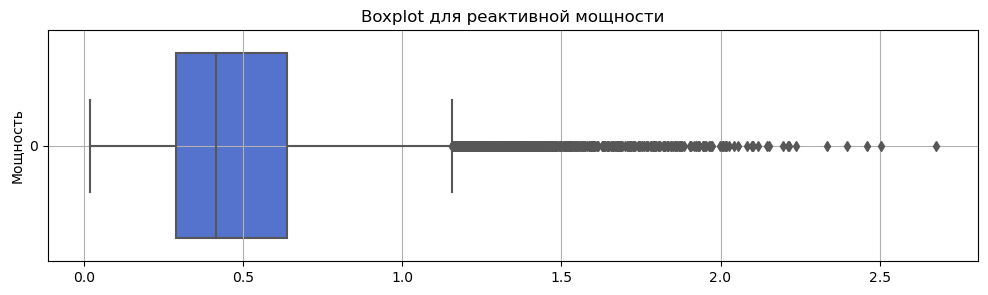

In [16]:
plt.figure(figsize=(12, 3))

sns.boxplot(data=data_arc_analysis['ReactivePower'], color='royalblue', orient='h')
plt.title('Boxplot для реактивной мощности')
plt.ylabel('Мощность')
plt.grid();

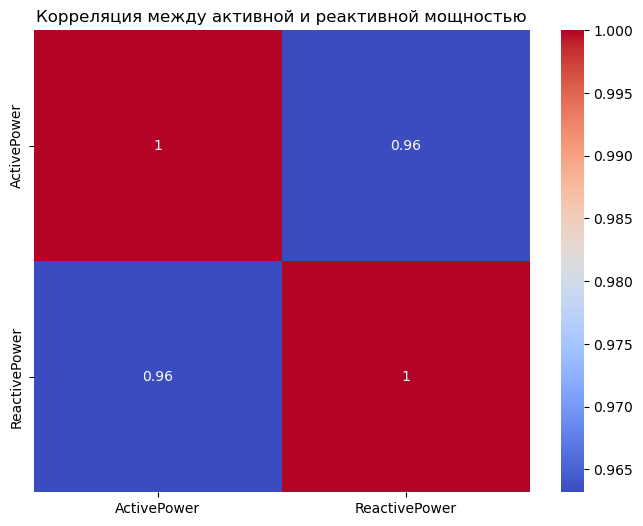

In [17]:
correlation_matrix = data_arc_analysis[['ActivePower', 'ReactivePower']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title('Корреляция между активной и реактивной мощностью');

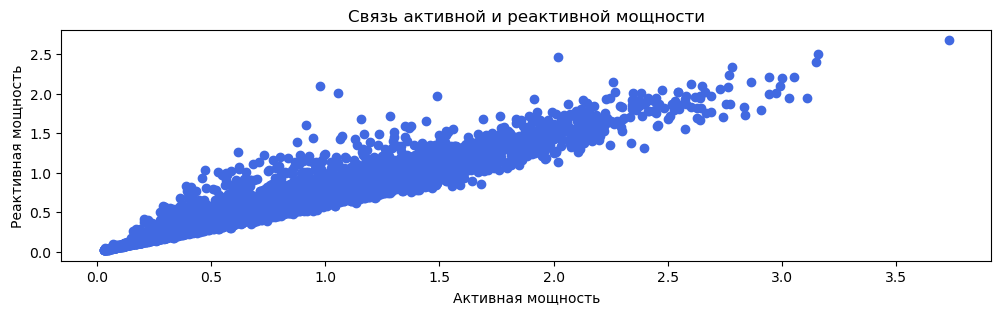

In [18]:
plt.figure(figsize=(12, 3))
plt.scatter(data_arc_analysis['ActivePower'], data_arc_analysis['ReactivePower'], color='royalblue')
plt.title('Связь активной и реактивной мощности')
plt.xlabel('Активная мощность')
plt.ylabel('Реактивная мощность');

/Users/vs/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/vs/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


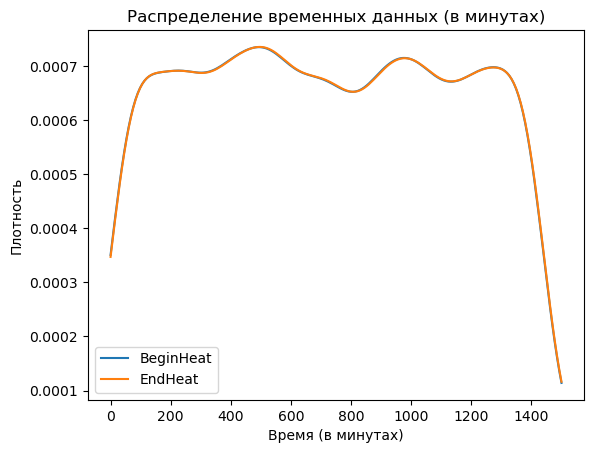

In [19]:
for column in ['BeginHeat', 'EndHeat']:
    sns.kdeplot(data_arc[column], label=column, clip=(0,1500))
# Настройки графика
plt.title('Распределение временных данных (в минутах)')
plt.xlabel('Время (в минутах)')
plt.ylabel('Плотность')

# Добавление легенды
plt.legend()

# Отображение графика
plt.show();

### Создание признаков

In [20]:
data_arc['TimeDifference'] = data_arc['EndHeat'] - data_arc['BeginHeat']

In [21]:
data_arc['PowerCorr'] = data_arc['ActivePower'] / data_arc['ReactivePower']

In [22]:
data_arc['KeyCount'] = data_arc['key'].map(data_arc['key'].value_counts())

In [23]:
data_arc.head(10)

,key,BeginHeat,EndHeat,ActivePower,ReactivePower,TimeDifference,PowerCorr,KeyCount
0,1,662,666,0.976059,0.687084,4,1.420582,5
1,1,667,670,0.805607,0.520285,3,1.548395,5
2,1,671,674,0.744363,0.498805,3,1.492292,5
3,1,678,684,1.659363,1.062669,6,1.561504,5
4,1,686,688,0.692755,0.414397,2,1.671717,5
5,2,694,696,0.438063,0.283043,2,1.547690,4
6,2,698,704,1.296415,0.892914,6,1.451893,4
7,2,706,708,0.490377,0.305281,2,1.606312,4
8,2,709,713,0.827743,0.516874,4,1.601441,4
9,3,726,731,1.062053,0.671494,5,1.581626,5


## Данные об объёме сыпучих материалов

Таблица steel.data_bulk
* key — номер партии;
* Bulk1 … Bulk15 — объём подаваемого материала.

In [24]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [25]:
data_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [26]:
data_bulk.sample(5)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
1595,1654,NaN,NaN,56.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150.0,NaN
2564,2662,NaN,NaN,150.0,NaN,NaN,128.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,248.0,NaN
241,258,NaN,NaN,NaN,NaN,NaN,76.0,NaN,NaN,NaN,NaN,NaN,204.0,NaN,151.0,154.0
3114,3227,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,208.0,NaN,130.0,202.0
2789,2895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,286.0,NaN,164.0,104.0


In [27]:
data_bulk['Bulk 1'].value_counts()

Bulk 1
27.0     75
46.0     30
48.0     16
44.0     16
31.0     14
28.0     11
54.0     10
34.0      6
29.0      6
26.0      5
22.0      5
30.0      5
38.0      5
62.0      3
52.0      3
73.0      3
39.0      2
37.0      2
50.0      2
92.0      2
36.0      2
16.0      2
24.0      2
43.0      2
32.0      1
19.0      1
104.0     1
69.0      1
74.0      1
118.0     1
47.0      1
78.0      1
21.0      1
67.0      1
63.0      1
51.0      1
58.0      1
83.0      1
33.0      1
60.0      1
65.0      1
90.0      1
75.0      1
94.0      1
185.0     1
10.0      1
41.0      1
Name: count, dtype: int64

In [28]:
bulk_columns = [col for col in data_bulk.columns if "Bulk " in col]

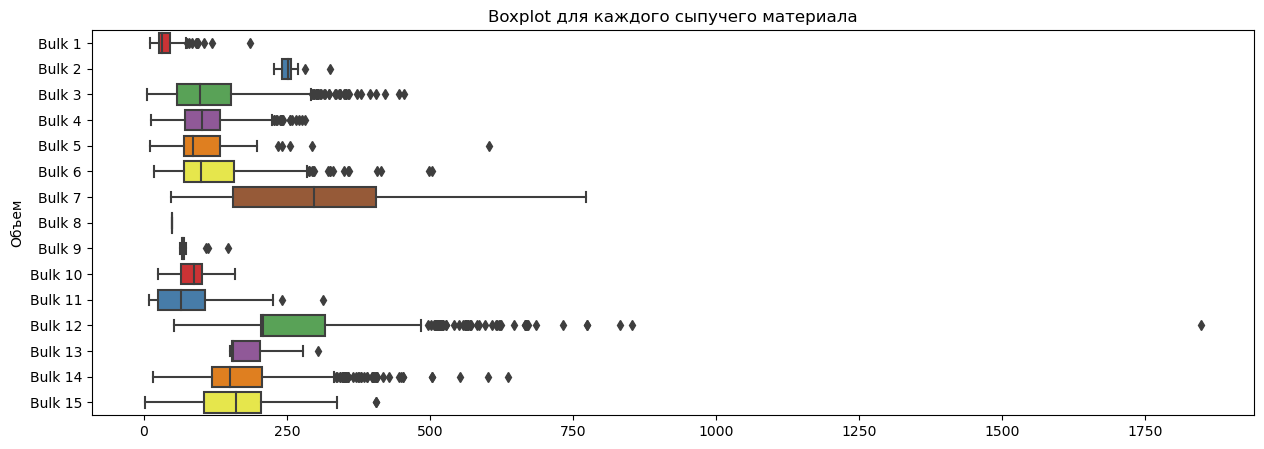

In [29]:
plt.figure(figsize=(15, 5))
sns.boxplot(data=data_bulk[bulk_columns], orient='h', palette='Set1')
plt.title('Boxplot для каждого сыпучего материала')
plt.ylabel('Объем')
plt.show()

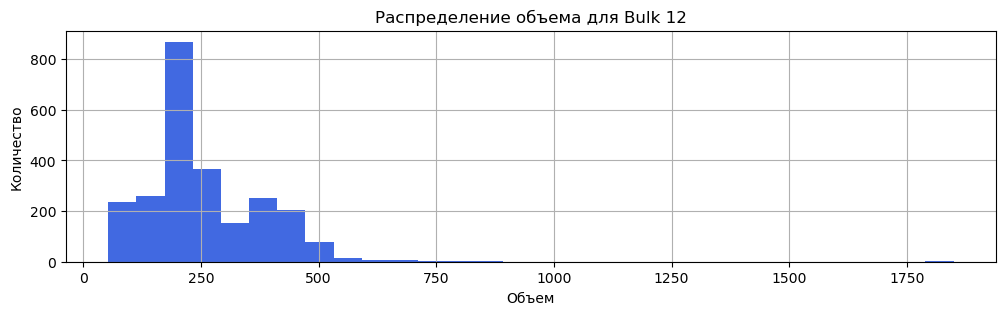

In [30]:
plt.figure(figsize=(12, 3))
data_bulk['Bulk 12'].hist(bins=30, color='royalblue')
plt.title(f'Распределение объема для Bulk 12')
plt.xlabel('Объем')
plt.ylabel('Количество')
plt.grid(True)
plt.show()

In [31]:
data_bulk.fillna(0, inplace=True)

In [32]:
data_bulk.duplicated().sum()

0

## Данные о времени подачи сыпучих материалов

Таблица steel.data_bulk_time
* key — номер партии;
* Bulk1 … Bulk15 — время подачи материала.

In [33]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [34]:
data_bulk_time.describe()

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


In [35]:
data_bulk_time.sample(5)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3041,3150,None,None,02:24:57,None,None,None,None,None,None,None,None,None,None,None,None
2934,3042,None,None,None,None,None,18:12:03,None,None,None,None,None,None,None,18:05:06,None
1812,1873,None,None,22:13:14,None,None,None,None,None,None,None,None,21:39:55,None,21:39:55,21:39:55
244,260,None,None,None,03:46:01,None,None,None,None,None,None,None,03:40:44,None,03:40:44,03:40:44
1674,1732,None,None,22:21:58,22:21:59,None,None,None,None,None,None,None,22:18:26,None,22:18:26,22:18:26


In [36]:
data_bulk_time.duplicated().sum()

0

In [37]:
for i in range(1, 16):
    data_bulk_time[f"Bulk {i}"] = pd.to_datetime(data_bulk_time[f"Bulk {i}"], format='%H:%M:%S').dt.hour * 60 + pd.to_datetime(data_bulk_time[f"Bulk {i}"], format='%H:%M:%S').dt.minute

/Users/vs/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/vs/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/vs/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/vs/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values

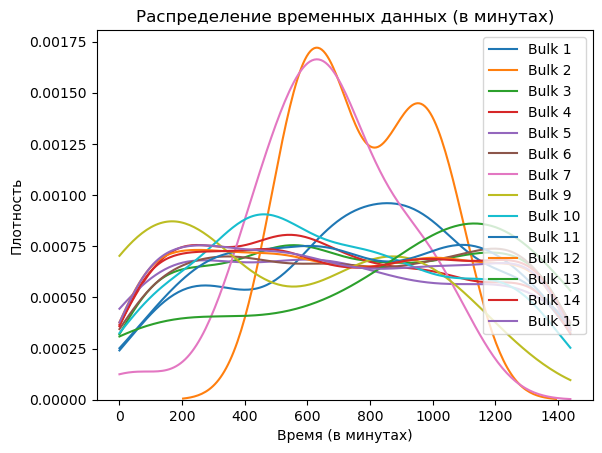

In [38]:
for i in range(1, 16):
    sns.kdeplot(data_bulk_time[data_bulk_time[f'Bulk {i}'] > 0][f'Bulk {i}'], label=f'Bulk {i}', clip=(1, 1439))

plt.title('Распределение временных данных (в минутах)')
plt.xlabel('Время (в минутах)')
plt.ylabel('Плотность')
plt.legend()
plt.show();

In [39]:
data_bulk_time.fillna(0, inplace=True)

In [40]:
data_bulk_time.duplicated().sum()

0

## Данные о продувке сплава газом

Таблица steel.data_gas
* key — номер партии;
* gas — объём подаваемого газа.

In [41]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [42]:
data_gas.describe()

,key,gas
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [43]:
data_gas.sample(5)

,key,gas
1900,1903,11.998700
1071,1074,9.968861
2302,2305,1.658822
2252,2255,10.144275
1796,1799,6.740204


In [44]:
data_gas.duplicated().sum()

0

/Users/vs/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


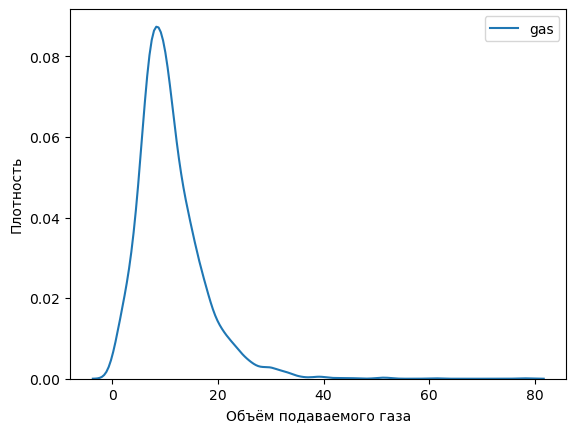

In [45]:
sns.kdeplot(data_gas['gas'], label='gas')

plt.xlabel('Объём подаваемого газа')
plt.ylabel('Плотность')
plt.legend()
plt.show();

## Данные об измерениях температуры

Таблица steel.data_temp
* key — номер партии;
* MesaureTime — время замера;
* Temperature — значение температуры.

In [46]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          15907 non-null  int64  
 1   MesaureTime  15907 non-null  object 
 2   Temperature  13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [47]:
data_temp.describe()

,key,Temperature
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


In [48]:
data_temp.sample(5)

,key,MesaureTime,Temperature
12666,2573,21:24:41,NaN
4694,935,00:45:21,1576.0
15598,3170,19:59:11,NaN
10603,2146,23:36:32,1584.0
3045,597,10:18:12,1602.0


In [49]:
data_temp["MesaureTime"] = pd.to_datetime(data_temp["MesaureTime"], format='%H:%M:%S').dt.time

/Users/vs/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


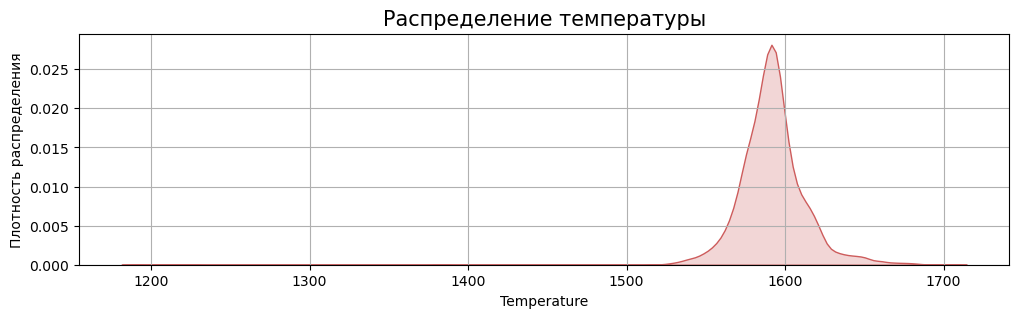

In [50]:
plt.figure(figsize=(12, 3))
sns.kdeplot(data_temp['Temperature'], color='indianred', legend=True, fill=True)
plt.xlabel('Temperature')
plt.ylabel('Плотность распределения')
plt.title('Распределение температуры', fontsize=15)
plt.grid();

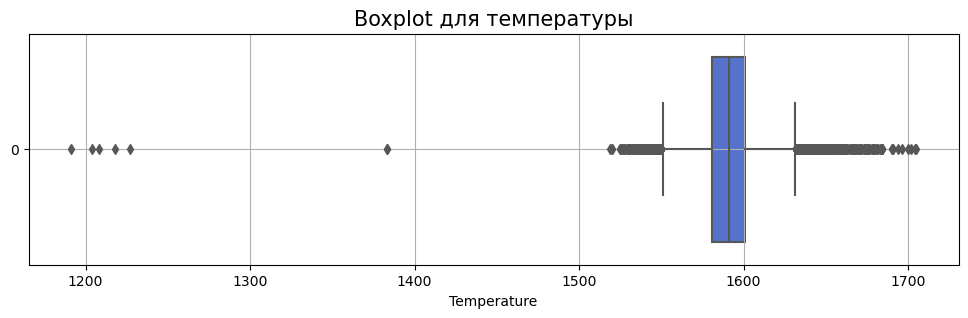

In [51]:
plt.figure(figsize=(12, 3))
sns.boxplot(data=data_temp['Temperature'], orient='h', color='royalblue')
plt.xlabel('Temperature')
plt.title('Boxplot для температуры', fontsize=15)
plt.grid()

In [52]:
data_temp = data_temp.dropna(subset=['Temperature'])

In [53]:
data_temp.duplicated().sum()

0

In [54]:
keys = data_temp['key'].unique()
data_temp_t = pd.DataFrame(columns=['key', 'start', 'temperature_1', 'end', 'temperature_2'])

for key in keys:
    sorted_data = data_temp[data_temp['key']==key].sort_values(by='MesaureTime')
    temp1 = sorted_data.iloc[0]['Temperature']
    temp2 = sorted_data.iloc[-1]['Temperature']
    t1 = sorted_data.iloc[0]['MesaureTime']
    t2 = sorted_data.iloc[-1]['MesaureTime']
    data_temp_t.loc[len(data_temp_t)] = [key, t1, temp1, t2, temp2]

In [55]:
data_temp_t

,key,start,temperature_1,end,temperature_2
0,1,11:16:18,1571.0,11:30:39,1613.0
1,2,11:37:27,1581.0,11:59:12,1602.0
2,3,12:13:17,1596.0,12:34:57,1599.0
3,4,12:52:57,1601.0,12:59:25,1625.0
4,5,13:23:19,1576.0,13:36:01,1602.0
...,...,...,...,...,...
3211,3237,22:44:04,1569.0,22:44:04,1569.0
3212,3238,23:30:31,1584.0,23:30:31,1584.0
3213,3239,01:31:47,1598.0,01:31:47,1598.0
3214,3240,02:39:01,1617.0,02:39:01,1617.0


In [56]:
data_temp = data_temp_t
data_temp.columns = ['key', 'start', 'temperature_1', 'end', 'temperature_2']
data_temp = data_temp.reset_index()
data_temp = data_temp.drop(['index'], axis=1)
data_temp.head()

,key,start,temperature_1,end,temperature_2
0,1,11:16:18,1571.0,11:30:39,1613.0
1,2,11:37:27,1581.0,11:59:12,1602.0
2,3,12:13:17,1596.0,12:34:57,1599.0
3,4,12:52:57,1601.0,12:59:25,1625.0
4,5,13:23:19,1576.0,13:36:01,1602.0


In [57]:
data_temp['start'] = pd.to_datetime(data_temp['start'], format='%H:%M:%S').dt.hour * 60 + pd.to_datetime(data_temp['start'], format='%H:%M:%S').dt.minute
data_temp['end'] = pd.to_datetime(data_temp['end'], format='%H:%M:%S').dt.hour * 60 + pd.to_datetime(data_temp['end'], format='%H:%M:%S').dt.minute

data_temp['process_time'] = data_temp['end'] - data_temp['start']
data_temp = data_temp.drop(columns=['start', 'end'], axis=1)
data_temp.head()

,key,temperature_1,temperature_2,process_time
0,1,1571.0,1613.0,14
1,2,1581.0,1602.0,22
2,3,1596.0,1599.0,21
3,4,1601.0,1625.0,7
4,5,1576.0,1602.0,13


In [58]:
data_temp.shape[0]

3216

In [59]:
data_temp = data_temp.query('temperature_1 > 1500 & temperature_2 > 1500')
data_temp.shape[0]

3211

## Данные об объёме проволочных материалов

Таблица steel.data_wire
* key — номер партии;
* Wire1 … Wire15 — объём подаваемых проволочных материалов.

In [60]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [61]:
data_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [62]:
data_wire.sample(5)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
1661,1741,156.499191,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2525,2658,50.013599,75.068245,NaN,NaN,NaN,NaN,NaN,NaN,NaN
207,229,154.321441,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2427,2554,97.144318,30.069521,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2575,2709,117.106079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
data_wire.duplicated().sum()

0

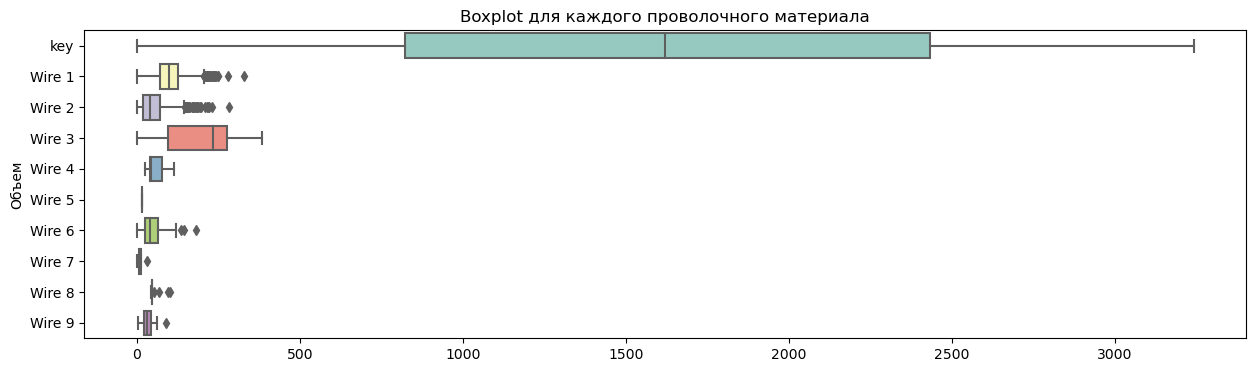

In [64]:
plt.figure(figsize=(15, 4))
sns.boxplot(data=data_wire, orient='h', palette='Set3')
plt.title('Boxplot для каждого проволочного материала')
plt.ylabel('Объем')
plt.show()

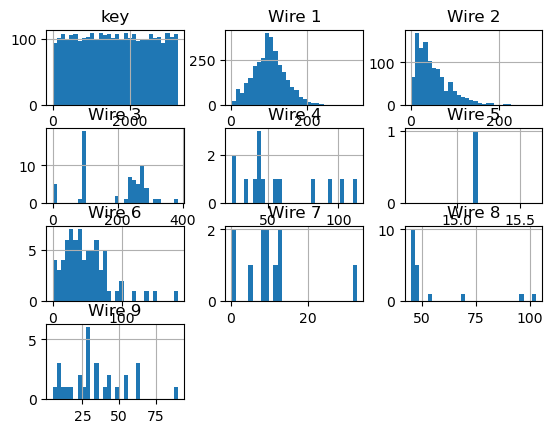

In [65]:
data_wire.hist(bins=30)
plt.xlabel('Объем')
plt.ylabel('Количество')
plt.grid(True)
plt.show()

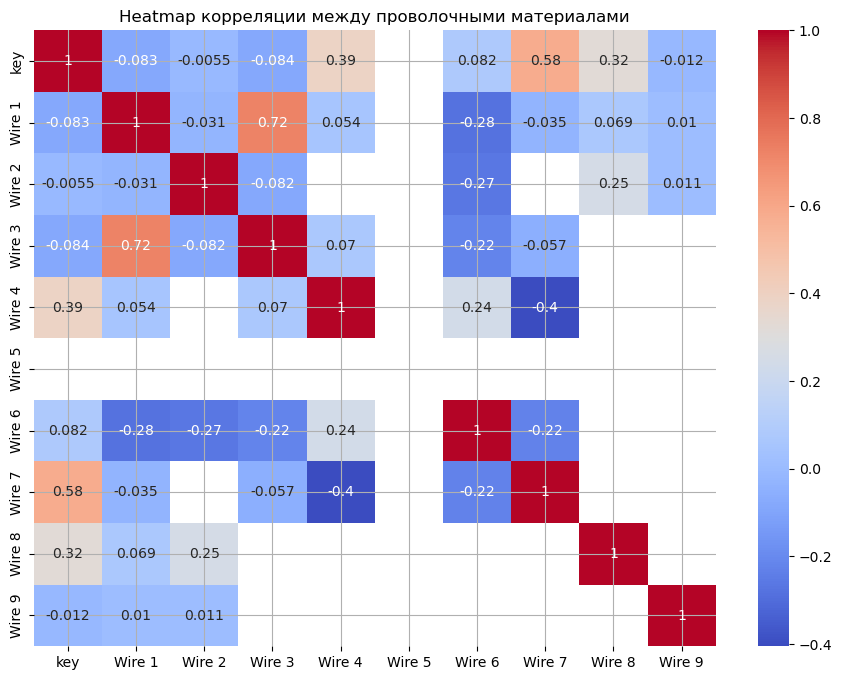

In [66]:
correlation = data_wire.corr()
plt.figure(figsize=(11, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Heatmap корреляции между проволочными материалами')
plt.grid();

In [67]:
data_wire.fillna(0, inplace=True)

## Данные о времени подачи проволочных материалов

Таблица steel.data_wire_time
* key — номер партии;
* Wire1 … Wire15 — время подачи проволочных материалов.

In [68]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [69]:
data_wire_time.describe()

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


In [70]:
data_wire_time.sample(5)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
513,548,17:46:05,None,None,None,None,None,None,None,None
1140,1208,02:24:19,02:25:38,None,None,None,None,None,None,None
1715,1802,08:23:05,None,None,None,None,None,None,None,None
2839,2992,00:28:09,None,None,None,None,None,None,None,None
1843,1933,13:56:58,None,None,None,None,None,None,None,None


In [71]:
for i in range(1, 10):
    data_wire_time[f"Wire {i}"] = pd.to_datetime(data_wire_time[f"Wire {i}"], format='%H:%M:%S').dt.hour * 60 + pd.to_datetime(data_wire_time[f"Wire {i}"], format='%H:%M:%S').dt.minute

/Users/vs/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/vs/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/vs/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/vs/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values

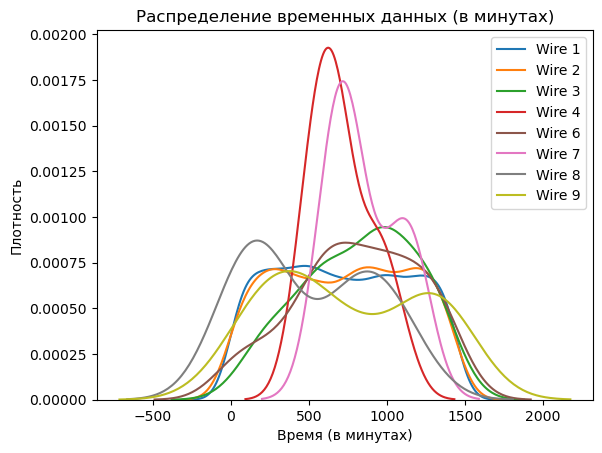

In [72]:
for i in range(1, 10):
    sns.kdeplot(data_wire_time[data_wire_time[f'Wire {i}'] > 0][f'Wire {i}'], label=f'Wire {i}', clip=(None, None))

# Настройки графика
plt.title('Распределение временных данных (в минутах)')
plt.xlabel('Время (в минутах)')
plt.ylabel('Плотность')

# Добавление легенды
plt.legend()

# Отображение графика
plt.show();

In [73]:
data_wire_time.fillna(0, inplace=True)

In [74]:
data_wire_time.duplicated().sum()

0

## Объединение и подготовка данных

In [75]:
df = data_arc.merge(right=data_bulk, how='inner', on='key')\
                  .merge(right=data_gas, how='inner', on='key')\
                  .merge(right=data_temp, how='inner', on='key')\
                  .merge(right=data_wire, how='inner', on='key')

In [76]:
df

,key,BeginHeat,EndHeat,ActivePower,ReactivePower,TimeDifference,PowerCorr,KeyCount,Bulk 1,Bulk 2,...,process_time,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,662,666,0.976059,0.687084,4,1.420582,5,0.0,0.0,...,14,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,667,670,0.805607,0.520285,3,1.548395,5,0.0,0.0,...,14,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,671,674,0.744363,0.498805,3,1.492292,5,0.0,0.0,...,14,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,678,684,1.659363,1.062669,6,1.561504,5,0.0,0.0,...,14,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,686,688,0.692755,0.414397,2,1.671717,5,0.0,0.0,...,14,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14173,3241,238,241,0.533670,0.354439,3,1.505675,5,0.0,0.0,...,0,63.117595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14174,3241,245,248,0.676604,0.523631,3,1.292139,5,0.0,0.0,...,0,63.117595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14175,3241,256,259,0.733899,0.475654,3,1.542928,5,0.0,0.0,...,0,63.117595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14176,3241,271,272,0.220694,0.145768,1,1.514004,5,0.0,0.0,...,0,63.117595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
df = df.drop(df.query('key == 2116').index).reset_index(drop=True)
df = df[df['Bulk 12'] < 1750]
df = df[df['Temperature'] >= 1500]

KeyError: 'Temperature'

In [ ]:
df.duplicated().sum()

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14161 entries, 0 to 14173
Data columns (total 36 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   key             14161 non-null  int64  
 1   BeginHeat       14161 non-null  int32  
 2   EndHeat         14161 non-null  int32  
 3   ActivePower     14161 non-null  float64
 4   ReactivePower   14161 non-null  float64
 5   TimeDifference  14161 non-null  int32  
 6   PowerCorr       14161 non-null  float64
 7   KeyCount        14161 non-null  int64  
 8   Bulk 1          14161 non-null  float64
 9   Bulk 2          14161 non-null  float64
 10  Bulk 3          14161 non-null  float64
 11  Bulk 4          14161 non-null  float64
 12  Bulk 5          14161 non-null  float64
 13  Bulk 6          14161 non-null  float64
 14  Bulk 7          14161 non-null  float64
 15  Bulk 8          14161 non-null  float64
 16  Bulk 9          14161 non-null  float64
 17  Bulk 10         14161 non-null  floa